In [73]:
import numpy as np
% tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [74]:
#load the dataset
(training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

Training_images shape:  (60000, 28, 28)
How many test samples are there:  10000
Training labels shape:  (60000,)
One label example:  9


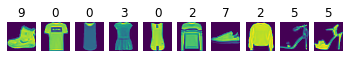

In [75]:
#Visualization
print("Training_images shape: ", training_images.shape)
print("How many test samples are there: ", test_images.shape[0])
print("Training labels shape: ", training_labels.shape)
print("One label example: ", training_labels[0])

#Visualize the images
fig, ax = plt.subplots(1,10)

for i in range(10):
  ax[i].imshow(training_images[i])
  ax[i].set_title(training_labels[i])
  ax[i].axis("off")




## Preprocessing

In [76]:
#perform necessary preprocessing steps
#for our autoencoder we do not need the labels

#normalizing the images
training_images = tf.data.Dataset.from_tensor_slices(training_images)
training_images = training_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
training_images = training_images.map(lambda img: img/255)

#Prepare the dataset
#this includes dividing the dataset into batches
training_data = training_images.batch(64)
training_data = training_data.shuffle(buffer_size= 64)
training_data = training_data.prefetch(16)


test_images_tsne = test_images[:1000]
test_images = tf.data.Dataset.from_tensor_slices(test_images)
test_images = test_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
test_images = test_images.map(lambda img: img/255)

test_data = test_images.batch(20)
test_data = test_data.shuffle(buffer_size= 20)
test_data = test_data.prefetch(10)


test_images_tsne = tf.data.Dataset.from_tensor_slices(test_images_tsne)
test_images_tsne = test_images_tsne.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
test_images_tsne = test_images_tsne.map(lambda img: img/255)
test_images_tsne = test_images_tsne.batch(20).prefetch(10)

test_labels = test_labels[:1000]

## 1. Convolutional Autoencoder

### 1.1. Encoder

In [77]:
class EncBlock(tf.keras.layers.Layer):
  def __init__(self, number_filters):
    super(EncBlock, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters = number_filters, activation = None, kernel_size = 3, padding = 'same')
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.ReLU()
    self.pool = tf.keras.layers.MaxPool2D(strides = (2,2))

  def call(self, input_x, training):
    x = self.conv(input_x)
    x = self.batch_norm(x, training)
    x = self.relu(x)
    x = self.pool(x)

    return x

class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()
    #self.dense_layer = tf.keras.layers.Dense(units = (28*28), activation = tf.keras.activations.relu)
    self.block1 = EncBlock(32)
    self.block2 = EncBlock(16)

    self.flatten = tf.keras.layers.Flatten()
    self.encoding_layer = tf.keras.layers.Dense(units = 10, activation = tf.keras.activations.softmax)

  def call(self, input_x, training):

    x = self.block1(input_x, training)
    x = self.block2(x, training)
    x = self.flatten(x)
    x = self.encoding_layer(x)

    return x


### 1.2. Decoder

In [78]:
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()
    #firstly restore dimensionality with a dense_layer
    
    self.dense_layer = tf.keras.layers.Dense(units = (7*7*32), activation = tf.keras.activations.relu)
    self.reshape = tf.keras.layers.Reshape((7,7,32))
    self.ConvT_1 = tf.keras.layers.Conv2DTranspose(filters =16, padding = 'same', kernel_size = 3, strides = (2,2))
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.relu1 = tf.keras.layers.ReLU()
    self.ConvT_2 = tf.keras.layers.Conv2DTranspose(filters =16, padding = 'same', kernel_size = 3, strides = (2,2))
    self.batch_norm2 = tf.keras.layers.BatchNormalization()
    self.relu2 = tf.keras.layers.ReLU()
    self.output_layer = tf.keras.layers.Conv2D(filters=1, padding = 'same', kernel_size = 3, activation= tf.keras.activations.sigmoid)

  def call(self, input_x, training):
    x = self.dense_layer(input_x)
    x = self.reshape(x)
    x = self.ConvT_1(x)
    x = self.batch_norm1(x, training)
    x = self.relu1(x)
    x = self.ConvT_2(x)
    x = self.batch_norm2(x, training)
    x = self.relu2(x)
    x = self.output_layer(x)

    return x

### 1.3. Autoencoder

In [79]:
class ConvoAE(tf.keras.Model):
  def __init__(self):
    super(ConvoAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    
  def call(self, input_x, training):
    x = self.encoder(input_x, training)
    x = self.decoder(x, training)

    return x

## Training

In [80]:
def train_step(model, samples, noisy_samples, loss_function, optimizer, training= True):
  with tf.GradientTape() as tape:

    reconstructed_img = model(noisy_samples, training)
    loss = loss_function(reconstructed_img, samples)
    
    gradients = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss

def test(model, input, loss_function, training= False):
  losses = []
  accuracies = []

  for image in input:
    reconstructed_img = model(image, training)
    loss = loss_function(reconstructed_img, image)

  return loss

def plot_img(input_images, model):
  
  #
  for image in input_images.take(1):
    image = np.reshape(image[0].numpy(),(1,28,28,1))

    #add noise
    noise = np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(image + 0.15 * noise, 0., 1.)

    image_rec = model(noisy_image, False)

    fig, ax = plt.subplots(1,3)
    ax[0].imshow(tf.squeeze(image))
    ax[0].set_title("input")
    ax[0].axis("off")
    ax[1].imshow(tf.squeeze(noisy_image))
    ax[1].set_title("noisy image")
    ax[1].axis("off")
    ax[2].imshow(tf.squeeze(image_rec))
    ax[2].set_title("reconstructed image")
    ax[2].axis("off")

    plt.show()


In [81]:
def timing(start):
    now = time.time()
    time_per_training_step = now - start
    # compute duration of an epoch
    return round(time_per_training_step, 2)

0 . epoch --------------------------------------------------------------------------------

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



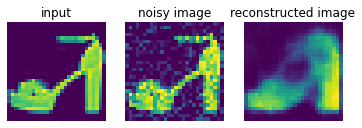

the training step and test evaluation took 24.83 seconds
train_loss 0.020085685
test_loss 0.018411651
1 . epoch --------------------------------------------------------------------------------


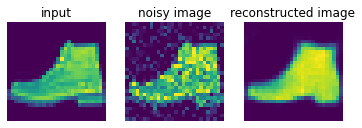

the training step and test evaluation took 24.92 seconds
train_loss 0.019305669
test_loss 0.017067745
2 . epoch --------------------------------------------------------------------------------


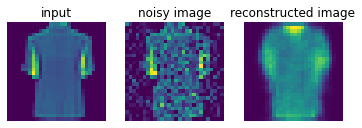

the training step and test evaluation took 25.08 seconds
train_loss 0.018635249
test_loss 0.017377177
3 . epoch --------------------------------------------------------------------------------


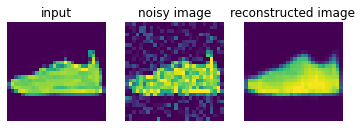

the training step and test evaluation took 25.46 seconds
train_loss 0.018192487
test_loss 0.018971762
4 . epoch --------------------------------------------------------------------------------


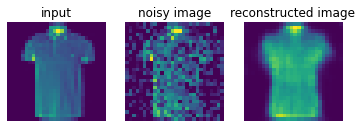

the training step and test evaluation took 25.07 seconds
train_loss 0.017836066
test_loss 0.018892245
5 . epoch --------------------------------------------------------------------------------


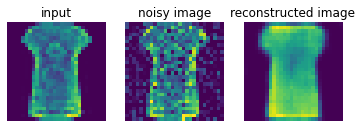

the training step and test evaluation took 25.32 seconds
train_loss 0.017487297
test_loss 0.014533857
6 . epoch --------------------------------------------------------------------------------


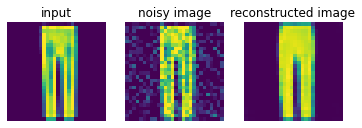

the training step and test evaluation took 24.37 seconds
train_loss 0.017221225
test_loss 0.015284124
7 . epoch --------------------------------------------------------------------------------


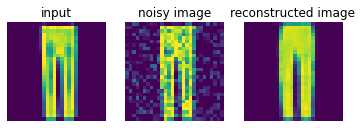

the training step and test evaluation took 24.92 seconds
train_loss 0.017036458
test_loss 0.015992934
8 . epoch --------------------------------------------------------------------------------


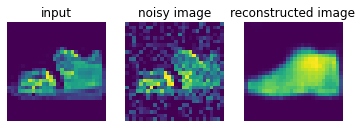

the training step and test evaluation took 24.53 seconds
train_loss 0.016867395
test_loss 0.015119554
9 . epoch --------------------------------------------------------------------------------


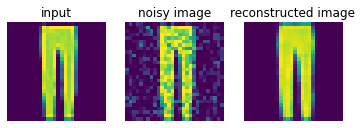

the training step and test evaluation took 24.49 seconds
train_loss 0.016702745
test_loss 0.014886165
10 . epoch --------------------------------------------------------------------------------


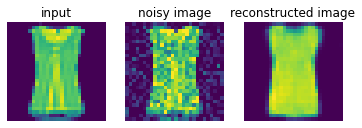

the training step and test evaluation took 24.94 seconds
train_loss 0.016575892
test_loss 0.015809247
11 . epoch --------------------------------------------------------------------------------


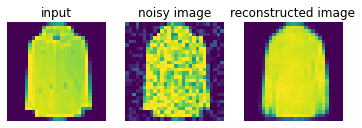

the training step and test evaluation took 24.81 seconds
train_loss 0.016446585
test_loss 0.015318586
12 . epoch --------------------------------------------------------------------------------


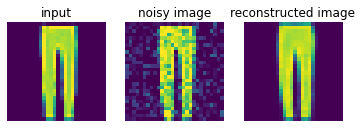

the training step and test evaluation took 25.1 seconds
train_loss 0.016311185
test_loss 0.014119944
13 . epoch --------------------------------------------------------------------------------


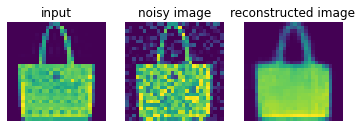

the training step and test evaluation took 24.77 seconds
train_loss 0.01620552
test_loss 0.015807852
14 . epoch --------------------------------------------------------------------------------


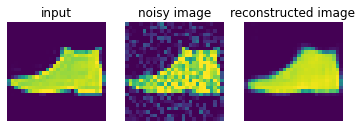

the training step and test evaluation took 25.28 seconds
train_loss 0.016129501
test_loss 0.013999566
15 . epoch --------------------------------------------------------------------------------


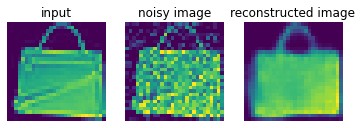

the training step and test evaluation took 24.91 seconds
train_loss 0.016043859
test_loss 0.015353794
16 . epoch --------------------------------------------------------------------------------


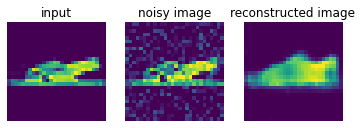

the training step and test evaluation took 24.58 seconds
train_loss 0.015964713
test_loss 0.013892727
17 . epoch --------------------------------------------------------------------------------


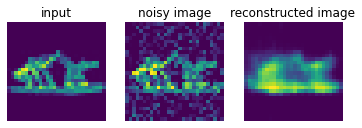

the training step and test evaluation took 25.27 seconds
train_loss 0.015884258
test_loss 0.016166523
18 . epoch --------------------------------------------------------------------------------


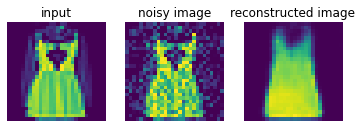

the training step and test evaluation took 24.89 seconds
train_loss 0.015820714
test_loss 0.011365221
19 . epoch --------------------------------------------------------------------------------


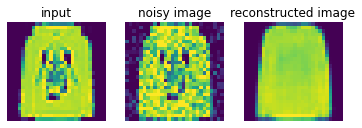

the training step and test evaluation took 25.16 seconds
train_loss 0.01576503
test_loss 0.0154824825


In [82]:
tf.keras.backend.clear_session()

conv_ae = ConvoAE()

#Define hyperparameters
#How many training epochs do we perform
epochs = 20
#define the learning rate which influences the magnitude with which we update the models parameters
learning_rate = 0.001

loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate)

running_average_factor = 0.95


steps = []
train_losses = []
test_losses = []

for epoch in range(epochs):
  print(epoch, ". epoch --------------------------------------------------------------------------------")
  steps.append(epoch)


  start = time.time()
  original_loss = 0
  for images in training_data:

    noise = np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(images + 0.15 * noise, 0., 1.)

    train_loss = train_step(conv_ae, images, noisy_images , loss_function, optimizer, training = True)
    
    original_loss = running_average_factor * original_loss + (1-running_average_factor) * train_loss
  train_losses.append(original_loss)
  test_loss = test(conv_ae,test_data, loss_function)
  test_losses.append(test_loss)

  plot_img(training_data,conv_ae)

  print(f"the training step and test evaluation took {timing(start)} seconds")
  #some sort of plotting
  print("train_loss", np.mean(train_losses))
  print("test_loss", test_loss.numpy())

## Latent Space Analysis

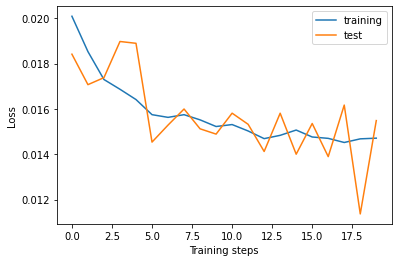

In [83]:
# plot losses
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

In [92]:
#TSNE stuff
from sklearn.manifold import TSNE

label_dict = {0: "tab:blue",1: "tab:green", 2: "tab:orange", 3: "tab:red", 4: "tab:purple",
               5: "tab:brown", 6: "tab:pink", 7: "tab:grey", 8: "tab:olive", 9: "tab:cyan"}

#walk through the test_data and produce embeddings
#athe data is batched
for image in test_images_tsne:
  embeddings.append(conv_ae.encoder(image))

embeddings_arr = np.array(embeddings)
embeddings_arr = np.reshape(embeddings_arr, (1000,10))

embedded_label = test_labels



In [112]:
#Visualization
import matplotlib.colors as mcolors
def plot_embeddings(embeddings_arr ,embedded_label, perplexity):

  embeddings_arr = TSNE(n_components=2,perplexity = perplexity).fit_transform(embeddings_arr)
  embedded_x = embeddings_arr[:,0]
  embedded_y = embeddings_arr[:,1]

  fig, ax = plt.subplots()

  for x, y, group in zip(embedded_x, embedded_y, embedded_label):
    ax.scatter(x, y, c = label_dict[group], alpha = 0.5, s = 10)

  plt.xlabel("dimension 1")
  plt.ylabel("dimension 2")
  fig.suptitle("tsne perplexity = "+ str(perplexity))


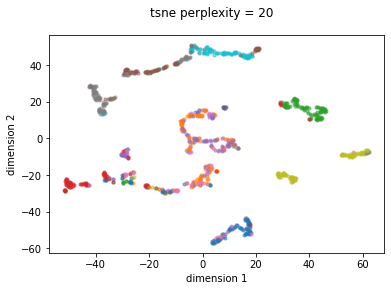

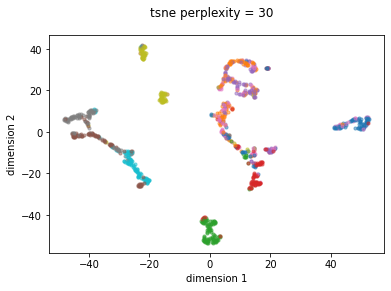

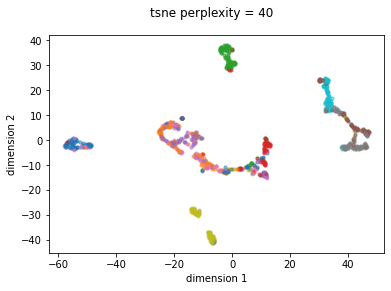

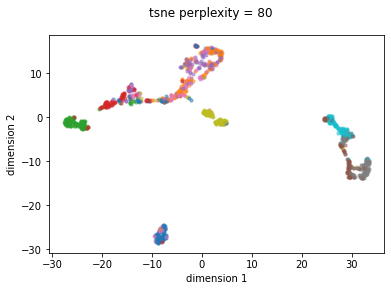

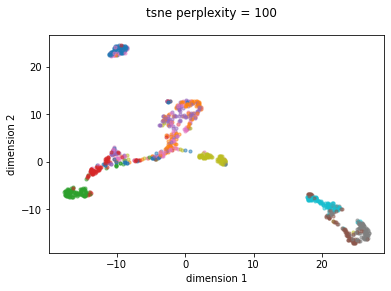

In [113]:

plot_embeddings(embeddings_arr, embedded_label, 20)
plot_embeddings(embeddings_arr, embedded_label, 30)
plot_embeddings(embeddings_arr, embedded_label, 40)
plot_embeddings(embeddings_arr, embedded_label, 80)
plot_embeddings(embeddings_arr, embedded_label, 100)


plt.show()

##### Side note:
This week noone of us was able to drop by in the Q and A sessions, therefore our homework might not be done in the way you expected. We tried our best to produce a result that fits your task description which we were somtimes unsure about.

## Interpretation of the visualization of the embeddings
In t-SNE visualization of our embeddings we can see that our model differentiate some classes quite good, while other classes are to some extend mixed together. Also we can see that some classes are very close to each other, forming around 5 global clusters, which makes sense, since for example sneakers, ankleboots and sandals are quite similar.